In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Ayarlar
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Dosya Yollari
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'wildfire_data_clean.parquet')
MODELS_DIR = os.path.join(BASE_DIR, 'results', 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

print("Kutuphaneler ve yollar hazir.")

Kutuphaneler ve yollar hazir.


In [8]:
def load_data():
    print("Veri okunuyor...")
    df = pd.read_parquet(DATA_PATH)
    
    X = df.drop(columns=['FIRE_SIZE_CLASS_ID', 'FIRE_SIZE'])
    y = df['FIRE_SIZE_CLASS_ID']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print(f"Egitim Seti: {X_train.shape}")
    print(f"Test Seti:   {X_test.shape}")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

Veri okunuyor...
Egitim Seti: (1504372, 20)
Test Seti:   (376093, 20)


In [9]:
def plot_learning_curve(train_loss, val_loss, model_name):
    # Egitim surecindeki hata  grafigini cizer
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Test Loss')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    # Modelin basarisini detayli metrics ile olcer
    print(f"\n--- {model_name} ANALIZI ---")
    y_pred = model.predict(X_test)
    
    # 1. Temel Metrikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    
    from sklearn.metrics import cohen_kappa_score
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"Kappa:     {kappa:.4f}")
    
    # 2. Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # 3. Detayli Rapor
    print(classification_report(y_test, y_pred))
    
    # Sonuclari dondur
    return {
        'Model': model_name,
        'Accuracy': acc,
        'F1_Score': f1,
        'Precision': prec,
        'Recall': rec,
        'Kappa_Score': kappa,
        'Class_G_Recall': classification_report(y_test, y_pred, output_dict=True).get('6', {}).get('recall', 0)
    }

# Sonuclari tutacak liste
results = []

LightGBM Egitiliyor...


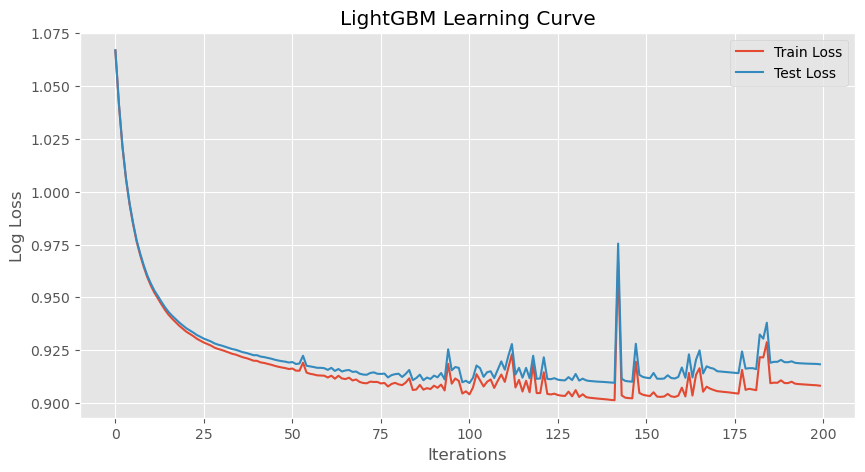


--- LightGBM ANALIZI ---
Accuracy:  0.6262
F1 Score:  0.5790
Precision: 0.5929
Recall:    0.6262
Kappa:     0.3223


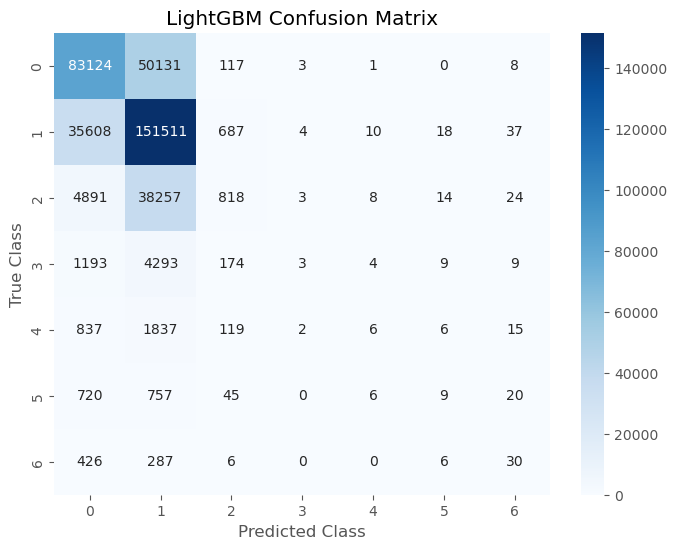

              precision    recall  f1-score   support

           0       0.66      0.62      0.64    133384
           1       0.61      0.81      0.70    187875
           2       0.42      0.02      0.04     44015
           3       0.20      0.00      0.00      5685
           4       0.17      0.00      0.00      2822
           5       0.15      0.01      0.01      1557
           6       0.21      0.04      0.07       755

    accuracy                           0.63    376093
   macro avg       0.34      0.21      0.21    376093
weighted avg       0.59      0.63      0.58    376093



In [10]:
print("LightGBM Egitiliyor...")

lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    n_jobs=-1,
    verbose=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="multi_logloss",
    callbacks=[]
)

# Loss degerlerini al
results_lgbm = lgbm.evals_result_
train_loss = results_lgbm['training']['multi_logloss']
val_loss = results_lgbm['valid_1']['multi_logloss']

# Grafik ve Analiz
plot_learning_curve(train_loss, val_loss, "LightGBM")
results.append(evaluate_model(lgbm, X_test, y_test, "LightGBM"))

CatBoost Egitiliyor...


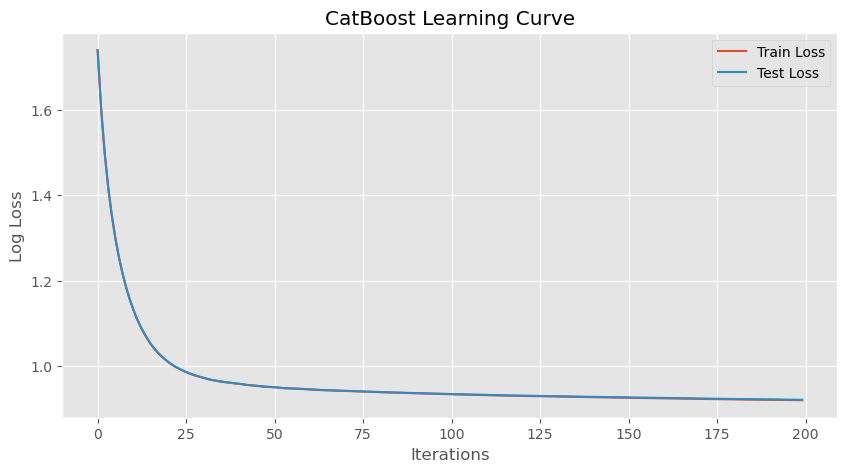


--- CatBoost ANALIZI ---
Accuracy:  0.6183
F1 Score:  0.5673
Precision: 0.5709
Recall:    0.6183
Kappa:     0.3049


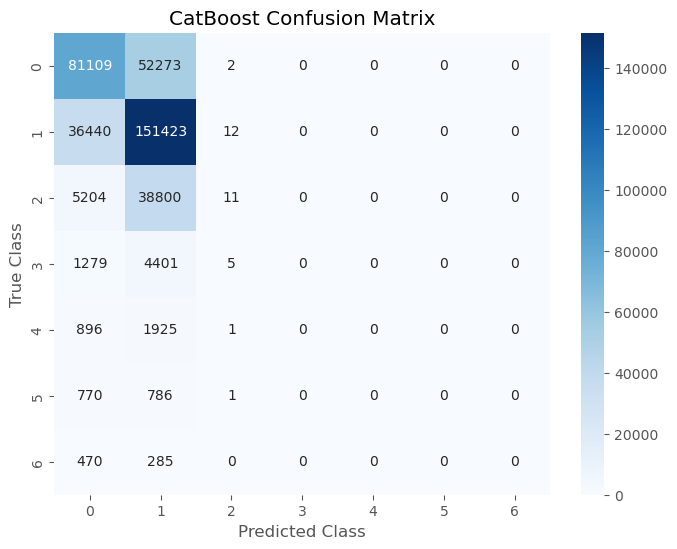

              precision    recall  f1-score   support

           0       0.64      0.61      0.62    133384
           1       0.61      0.81      0.69    187875
           2       0.34      0.00      0.00     44015
           3       0.00      0.00      0.00      5685
           4       0.00      0.00      0.00      2822
           5       0.00      0.00      0.00      1557
           6       0.00      0.00      0.00       755

    accuracy                           0.62    376093
   macro avg       0.23      0.20      0.19    376093
weighted avg       0.57      0.62      0.57    376093



In [11]:
print("CatBoost Egitiliyor...")

cat = CatBoostClassifier(
    iterations=200, 
    depth=6, 
    learning_rate=0.1, 
    loss_function='MultiClass',
    verbose=False,
    allow_writing_files=False
)

cat.fit(
    X_train, y_train, 
    eval_set=(X_test, y_test), 
    verbose=False,
    plot=False
)

# Loss degerlerini al
cat_res = cat.get_evals_result()
train_loss = cat_res['learn']['MultiClass']
val_loss = cat_res['validation']['MultiClass']

# Grafik ve Analiz
plot_learning_curve(train_loss, val_loss, "CatBoost")
results.append(evaluate_model(cat, X_test, y_test, "CatBoost"))

Random Forest Egitiliyor...

--- Random Forest ANALIZI ---
Accuracy:  0.6160
F1 Score:  0.5655
Precision: 0.5681
Recall:    0.6160
Kappa:     0.3024


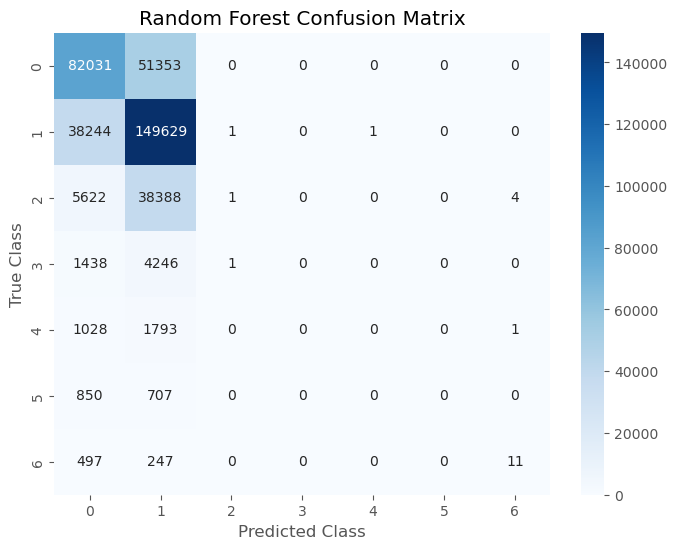

              precision    recall  f1-score   support

           0       0.63      0.61      0.62    133384
           1       0.61      0.80      0.69    187875
           2       0.33      0.00      0.00     44015
           3       0.00      0.00      0.00      5685
           4       0.00      0.00      0.00      2822
           5       0.00      0.00      0.00      1557
           6       0.69      0.01      0.03       755

    accuracy                           0.62    376093
   macro avg       0.32      0.20      0.19    376093
weighted avg       0.57      0.62      0.57    376093

Logistic Regression Egitiliyor...

--- Logistic Regression ANALIZI ---
Accuracy:  0.5731
F1 Score:  0.5204
Precision: 0.4896
Recall:    0.5731
Kappa:     0.2151


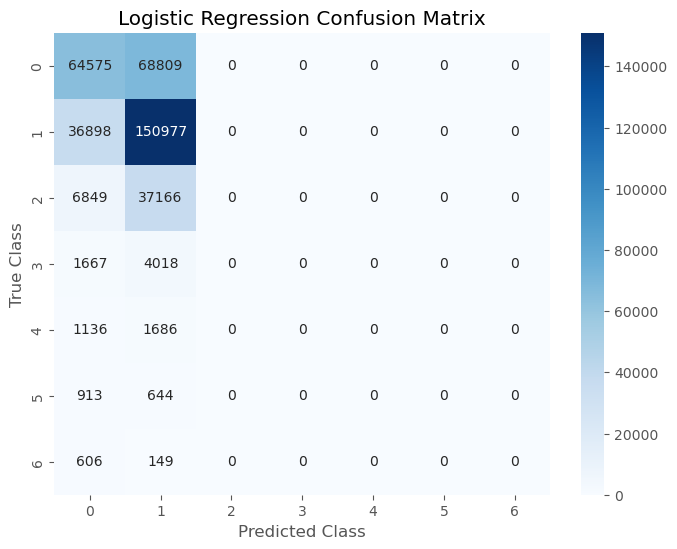

              precision    recall  f1-score   support

           0       0.57      0.48      0.52    133384
           1       0.57      0.80      0.67    187875
           2       0.00      0.00      0.00     44015
           3       0.00      0.00      0.00      5685
           4       0.00      0.00      0.00      2822
           5       0.00      0.00      0.00      1557
           6       0.00      0.00      0.00       755

    accuracy                           0.57    376093
   macro avg       0.16      0.18      0.17    376093
weighted avg       0.49      0.57      0.52    376093



In [12]:
# --- Random Forest ---
print("Random Forest Egitiliyor...")
rf = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    n_jobs=-1, 
    random_state=42
)
rf.fit(X_train, y_train)
results.append(evaluate_model(rf, X_test, y_test, "Random Forest"))

# --- Logistic Regression ---
print("Logistic Regression Egitiliyor...")
lr = LogisticRegression(
    max_iter=500, 
    n_jobs=-1, 
    solver='saga'
)
lr.fit(X_train, y_train)
results.append(evaluate_model(lr, X_test, y_test, "Logistic Regression"))

In [13]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='F1_Score', ascending=False)

print("TUM MODELLERIN KARSILASTIRMASI :")
display(df_results)

# Kaydet
df_results.to_csv(os.path.join(MODELS_DIR, 'imbalanced_results.csv'), index=False)

TUM MODELLERIN KARSILASTIRMASI :


,Model,Accuracy,F1_Score,Precision,Recall,Kappa_Score,Class_G_Recall
0,LightGBM,0.626178,0.579030,0.592856,0.626178,0.322343,0.039735
1,CatBoost,0.618312,0.567299,0.570926,0.618312,0.304877,0.000000
2,Random Forest,0.615997,0.565486,0.568081,0.615997,0.302384,0.014570
3,Logistic Regression,0.573135,0.520389,0.489591,0.573135,0.215107,0.000000
